# Dimension Dependence for Axial Modes Density $f_{\nu}(x) = \parallel\!\!x\!\!\parallel_{\infty}^4 \exp(-\!\!\parallel\!\!x\!\!\parallel_1)$
Runs around 9 minutes.

In [1]:
import slice_sampling as ss
import mcmc_utils as uti
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import time as ti
import matplotlib.pyplot as plt
from fastprogress import progress_bar

### Set up sampling itself

In [2]:
# set parameters
ds = range(10,101,10) # dimensions to be used
nd = len(ds)
itnum = int(1e5) # number of iterations for each dimension and sampler

In [3]:
# this may look weird but believe me, this is the most plausible value samples I managed to find
x_0_gen = lambda d: np.concatenate([np.array([5.0]), np.ones(d-1)])

In [4]:
log_density = lambda x: 4*np.log(alg.norm(x, ord=np.inf)) - alg.norm(x, ord=1)

In [5]:
density = lambda x: np.exp(log_density(x))

In [6]:
path_prefix = "../plots/axial_modes_"

In [7]:
w_gen = lambda d: 10.0

In [8]:
dpi = 250

### Make illustration

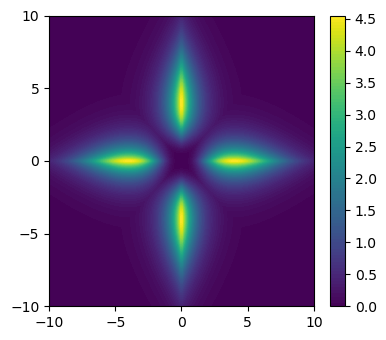

In [9]:
ext = 10
X1, X2, fnus = pfs.contour_precalc(300, -ext, ext, -ext, ext, density)
plt.figure(figsize=(4,3.5))
plt.yticks(range(-10,11,5))
plt.contourf(X1, X2, fnus, levels=100)
plt.colorbar()
plt.tight_layout()
plt.savefig(path_prefix + "target.png", dpi=dpi)
plt.show()

### Set up sampler comparison

In [10]:
samplers   = [ss.gibbsian_polar_ss, ss.hit_and_run_uniform_ss, ss.naive_elliptical_ss,  ss.elliptical_ss, ]
names      = ["GPSS", "HRUSS", "Untuned ESS", "Tuned ESS"]
long_names = ["Gibbsian Polar S.S.", "Hit-and-Run Uniform S.S.", "Untuned Elliptical S.S.", "Tuned Elliptical S.S."]
nsam = len(samplers)

In [11]:
# Compute sample radii asap to avoid having to store all samples for multiple samplers and dimensions
radii = [nd * [None] for _ in range(nsam)]
moxes = [nd * [None] for _ in range(nsam)]

for i_d, d in enumerate(progress_bar(ds)):
    x_0 = x_0_gen(d)
    w = w_gen(d)
    for i_s, sampler in enumerate(samplers):
        if i_s in [0,1]:
            samples = sampler(log_density, x_0, w, itnum, False)
        elif i_s == 2:
            samples = sampler(log_density, x_0, itnum, False)
        elif i_s == 3:
            var = float( ((5+d/10)/np.sqrt(d))**2 )
            log_likelihood = lambda x: -ss.log_prior_identity(var, x) + log_density(x)
            samples = sampler(var, log_likelihood, x_0, itnum, False)
        radii[i_s][i_d] = alg.norm(samples, axis=1)
        moxes[i_s][i_d] = np.argmax(np.abs(samples), axis=1)

In [12]:
# mean dwelling times
jumps = np.zeros((nsam, nd))
for i_s in range(nsam):
    for i_d in range(nd):
        jumps[i_s,i_d] = np.sum(moxes[i_s][i_d][1:] != moxes[i_s][i_d][:-1])
mean_dts = (itnum+1)/(jumps+1)

In [13]:
# maximum dwelling times
max_dts = np.zeros((nsam,nd))
for i_s in range(nsam):
    for i_d in range(nd):
        jump_inds = np.arange(itnum)[moxes[i_s][i_d][1:] != moxes[i_s][i_d][:-1]]
        dts = jump_inds[1:] - jump_inds[:-1]
        max_dts[i_s,i_d] = np.max(dts)

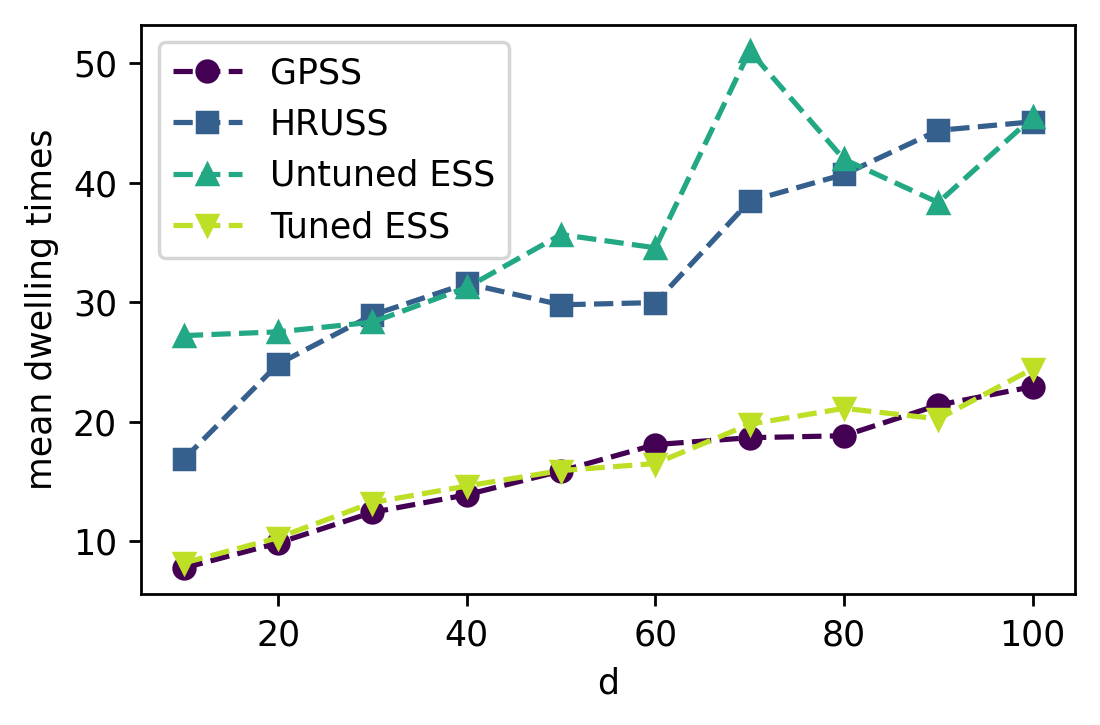

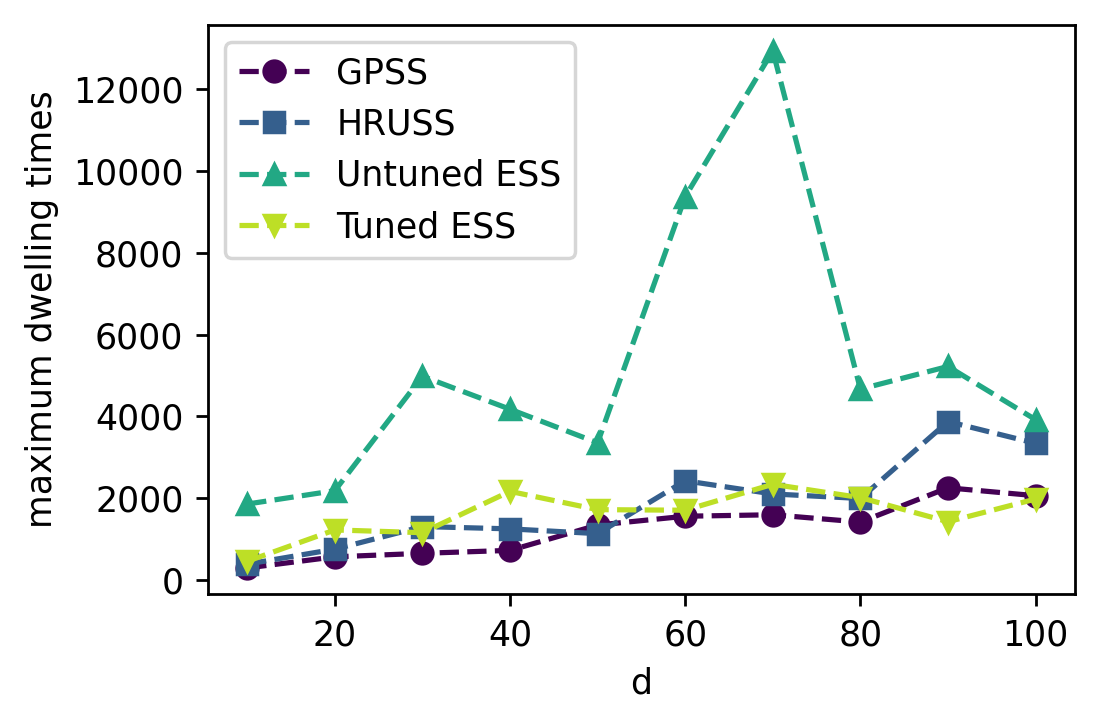

In [14]:
pfs.dim_dep_plot(ds, mean_dts, "mean dwelling times", names, dpi=dpi, filepath = path_prefix + "mean_dts.png")
pfs.dim_dep_plot(ds, max_dts, "maximum dwelling times", names, dpi=dpi, filepath = path_prefix + "max_dts.png")

In [15]:
def plot_moxes(moxes, snames, figsize=(10,10), size=1, linewidth=None, filepath=None):
    maxl = 50
    nsam = len(snames)
    plt.figure(figsize=figsize, dpi=dpi, constrained_layout=True)
    for i in range(nsam):
        plt.subplot(nsam, 1, i+1)
        plt.title(snames[i])
        plt.scatter(range(moxes[i].shape[0]), moxes[i], s=size)
    if filepath != None:
        plt.savefig(filepath)
    plt.show()

d = 100:


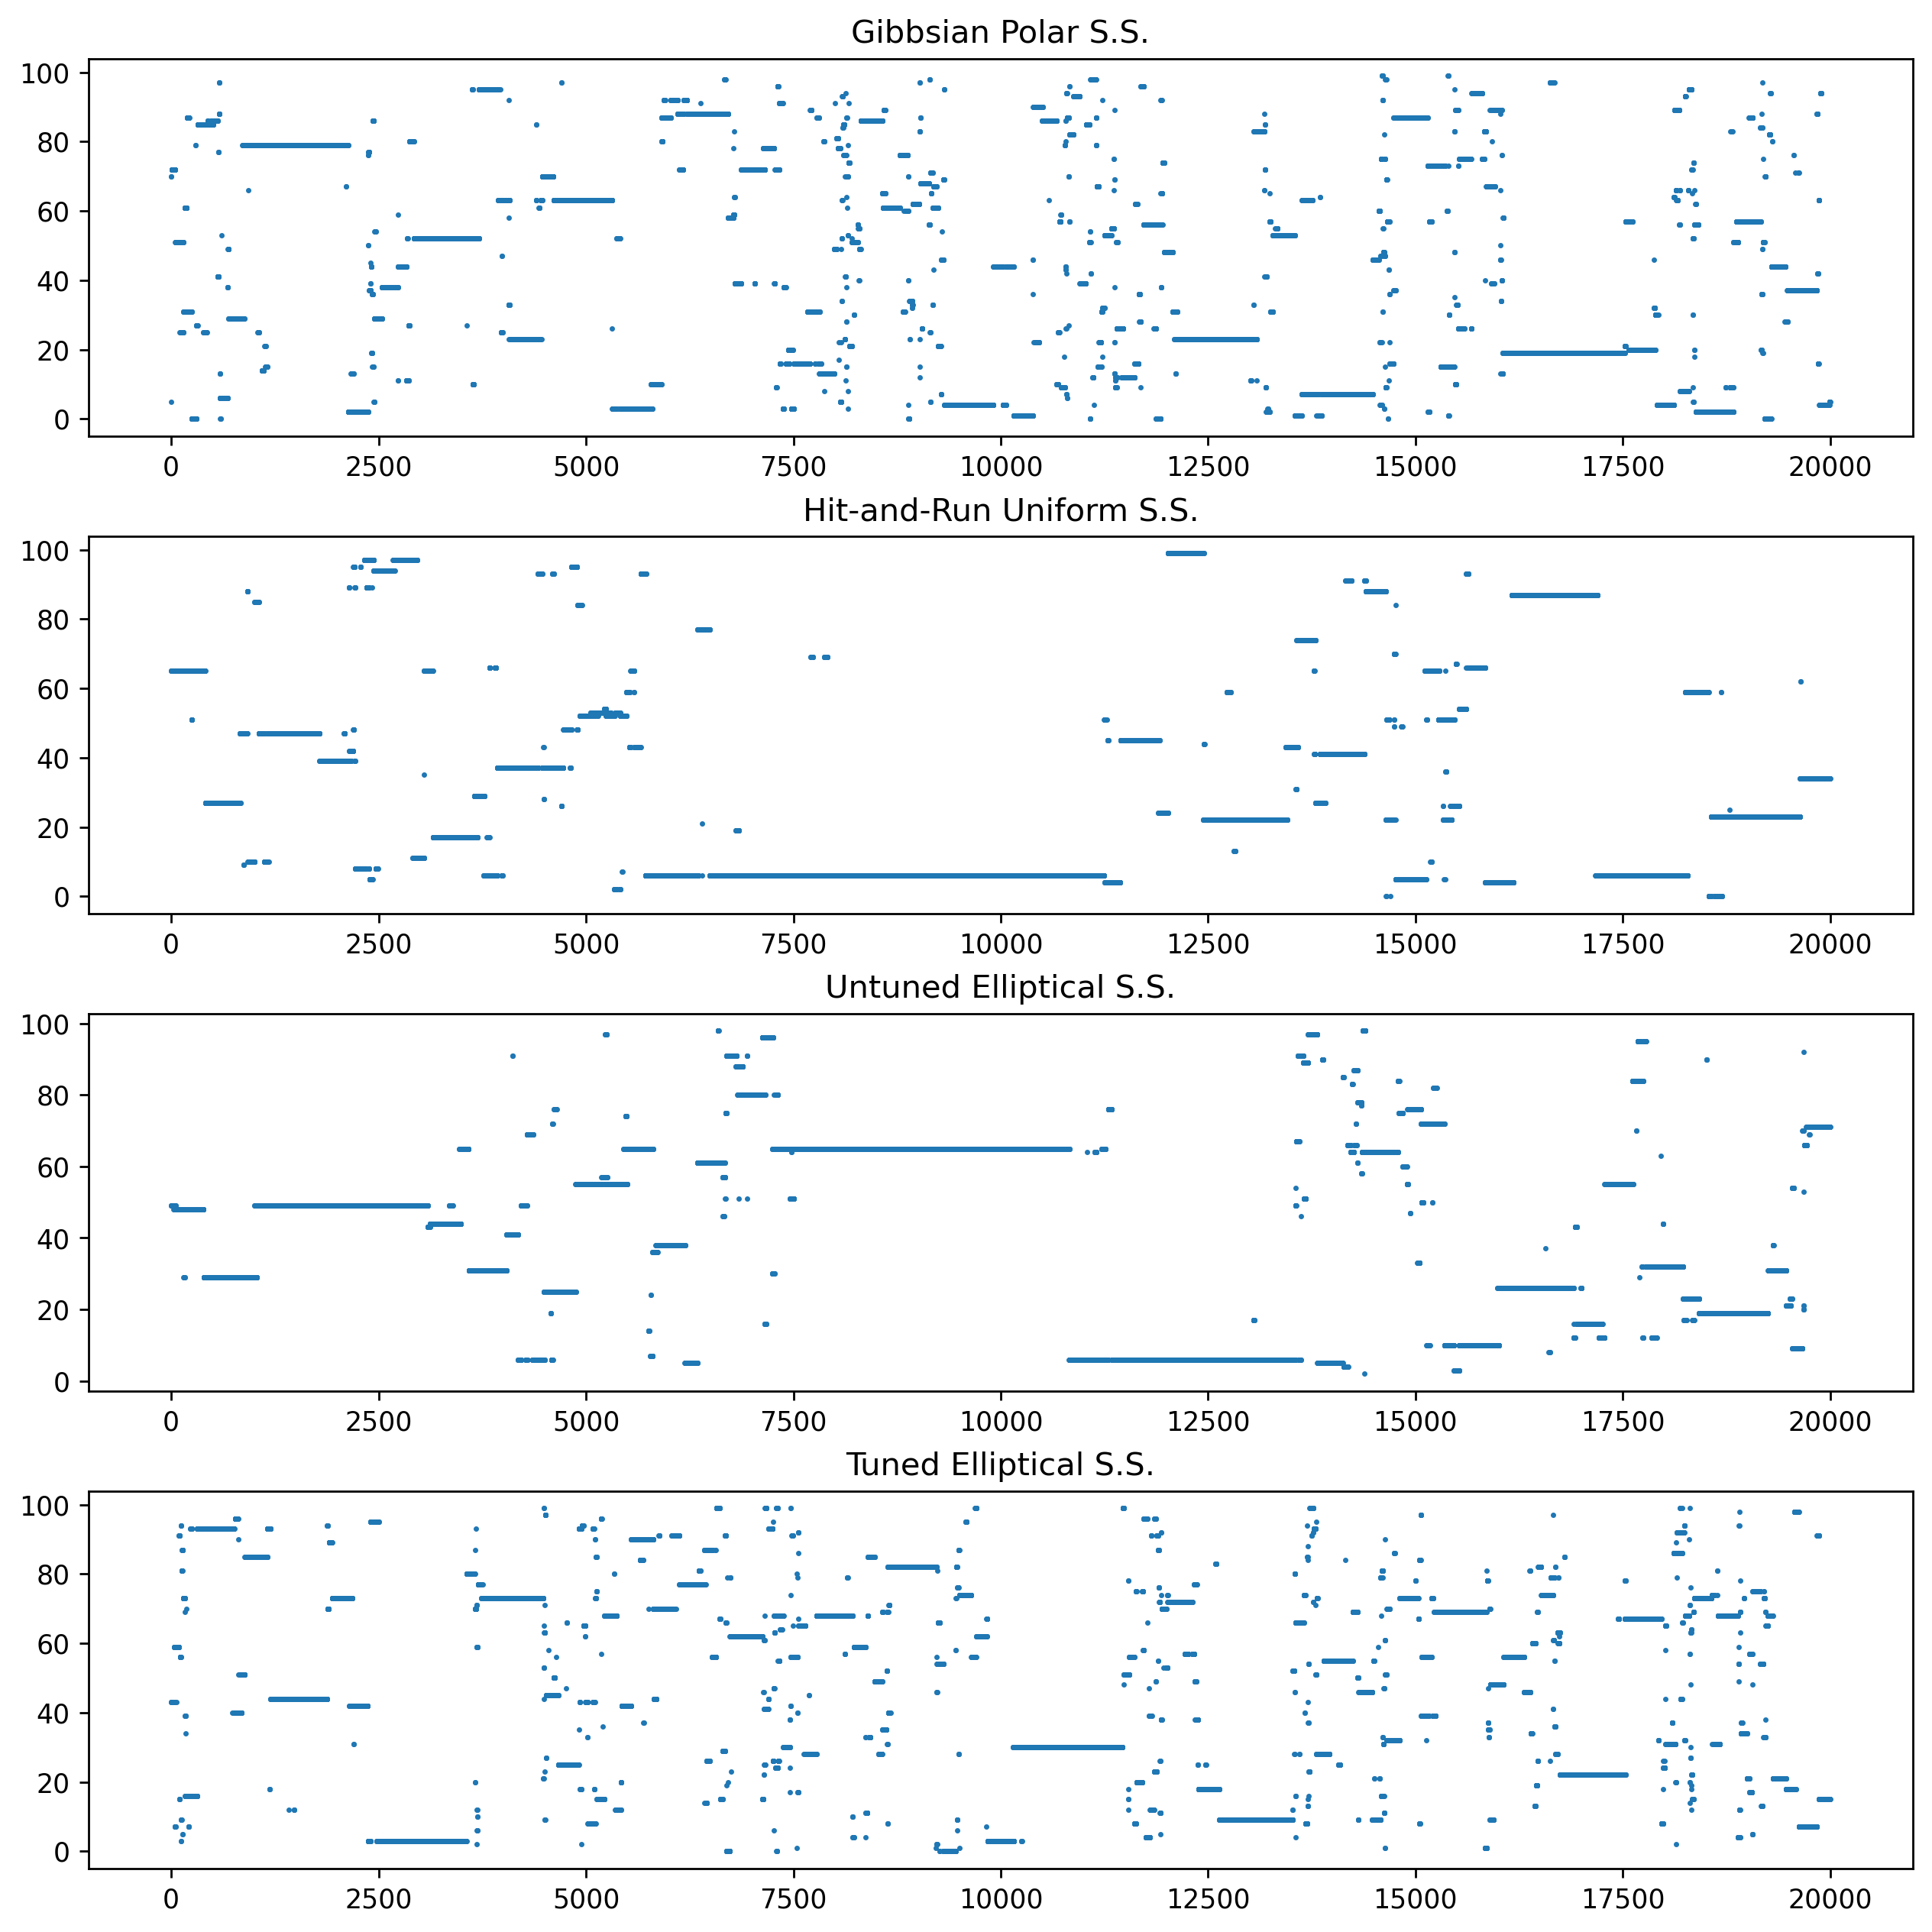

In [16]:
i_d = nd-1
window = int(2e4)
print("d = {}:".format(ds[i_d]))
pmoxes = [moxes[i_s][i_d][-window:] for i_s in range(nsam)]
plot_moxes(pmoxes, long_names, filepath = path_prefix + "moxes.png")